<a href="https://colab.research.google.com/github/inseungkang/learningalgos/blob/main/Controller_Inference_AdaptationTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import function and mount drive
# Import relevant functions and mount drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Inseung_LearningAlgos/
!pip3 install c3d

import numpy as np
import pandas as pd
import os
import fnmatch
import c3d
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Inseung_LearningAlgos


In [2]:
#@title Extract marker header location
# This is mainly for the tied-belt trials
# Extract maker header location from each c3d files

file_dir = '/content/drive/My Drive/Inseung_LearningAlgos/c3d files_splitbelt/'
file_list = os.listdir('/content/drive/My Drive/Inseung_LearningAlgos/c3d files_splitbelt/')
file_list.sort()
header_col_list = []
for filename in file_list:
  reader = c3d.Reader(open(file_dir+filename, 'rb'))
  markerLabel = reader.point_labels
  markerName = ['RASI','LASI','RPSI','LPSI','RANL','LANL']
  header_list = []
  for _, name in enumerate(markerName):
    for idx, label in enumerate(markerLabel):
      if name == label.strip():
        header_list.append(idx)
  header_col_list.append(header_list)

In [9]:
# This function uses the file input (npz file formate) and extract relevant data (marker, force)
# for the trial time, input in the start time in seconds and duration is in seconds
def extract_data(file_dir, file_header, start_time, duration):
  with np.load(file_dir) as data:
    marker_data = data['points']
    force_data = data['analog']

  force_sync = np.mean(force_data[:,14,:], axis=1)
  start_idx = np.argwhere(abs(force_sync) > np.max(abs(force_sync)/2))[0,0]
  start_idx = start_idx + start_time*6000
  end_idx = start_idx + duration*6000        

  foot_r = marker_data[start_idx:end_idx, file_header[4], 0:3]
  foot_l = marker_data[start_idx:end_idx, file_header[5], 0:3]
  com = np.mean(marker_data[start_idx:end_idx, file_header[0:4], 0:3], axis=1)
  force_r = np.mean(force_data[start_idx:end_idx, 0:3, :], axis=2)
  force_l = np.mean(force_data[start_idx:end_idx, 6:9, :], axis=2)
  
  return com, foot_r, foot_l, force_r, force_l

# Compute gait event index number (left and right). This will be in the order of left mid stance, right heel contact, right mid stance, and left heel contact
# This will be used to compute the com state during mid stance and evaluate the foot placement in the following heel contact
# here, using the com y position and foot y position, compute the mid stance (zero crossing) and heel contact (min value) from the signal: diff(com, foot)
# this is because com y location will be negative when the foot y is front of com and vice versa

def compute_gait_event(com, foot_r, foot_l):
  # left heel contact and mid stance index based on COM Y position subtracted from left foot Y 
  COM_Y_l = com[:,1] - foot_l[:,1]
  zc = np.where(np.diff(np.sign(COM_Y_l)))[0]

  hc_l = []
  ms_l = []
  for idx, value in enumerate(zc):
    if COM_Y_l[value+1] < 0:
      if idx < len(zc)-1:
        min_point = np.argmin(COM_Y_l[zc[idx]:zc[idx+1]])
        hc_idx = value+min_point
        ms_idx = zc[idx+1]
        hc_l.append(hc_idx)
        ms_l.append(ms_idx)

  # right heel contact and mid stance index based on COM Y position subtracted from right foot Y 
  COM_Y_r = com[:,1] - foot_r[:,1]
  zc = np.where(np.diff(np.sign(COM_Y_r)))[0]

  hc_r = []
  ms_r = []
  for idx, value in enumerate(zc):
    if COM_Y_r[value+1] < 0:
      if idx < len(zc)-1:
        min_point = np.argmin(COM_Y_r[zc[idx]:zc[idx+1]])
        hc_idx = value+min_point
        ms_idx = zc[idx+1]
        hc_r.append(hc_idx)
        ms_r.append(ms_idx)

  # mid stance and heel contact index for left and right might match in size so truncate the first on to match the MX4 size and concatenate
  # order of the gait event every loop is: ms_l, hc_r, ms_r, hc_l
  gait_event_idx = np.zeros((0,4))
  for idx, x in enumerate(ms_l):

    if idx+1 > len(hc_r)-1 or idx+1 > len(ms_r)-1 or idx+1 > len(hc_l)-1:
      break

    a = x

    if a < hc_r[idx]:
      b = hc_r[idx]
    else:
      b = hc_r[idx+1]

    if b < ms_r[idx]:
      c = ms_r[idx]
    else:
      c = ms_r[idx+1]

    if c < hc_l[idx]:
      d = hc_l[idx]
    else:
      d = hc_l[idx+1]
    
    gait_vec = np.array([int(a), int(b), int(c), int(d)])
    gait_event_idx = np.row_stack((gait_event_idx, gait_vec))

  return gait_event_idx

# Obtain delta P and Q using the COM state and foot XY position
def compute_pelvis_foot_state(com, foot_r, foot_l, gait_event_idx):
  # Obtain state vector for pelvis this is combination of position and velocity which was differentiated
  b, a = signal.butter(2, 0.125)

  COM_X_r = com[:,0] - foot_r[:,0]
  COM_Y_r = com[:,1] - foot_r[:,1]
  COM_Z_r = com[:,2] - foot_r[:,2]
  COM_X_l = com[:,0] - foot_l[:,0]
  COM_Y_l = com[:,1] - foot_l[:,1]
  COM_Z_l = com[:,2] - foot_l[:,2]

  COM_XX_r = np.append(np.diff(COM_X_r), np.diff(COM_X_r)[-1])
  COM_YY_r = np.append(np.diff(COM_Y_r), np.diff(COM_Y_r)[-1])
  COM_ZZ_r = np.append(np.diff(COM_Z_r), np.diff(COM_Z_r)[-1])
  COM_XX_l = np.append(np.diff(COM_X_l), np.diff(COM_X_l)[-1])
  COM_YY_l = np.append(np.diff(COM_Y_l), np.diff(COM_Y_l)[-1])
  COM_ZZ_l = np.append(np.diff(COM_Z_l), np.diff(COM_Z_l)[-1])

  COM_XX_r = signal.filtfilt(b, a, COM_XX_r)
  COM_YY_r = signal.filtfilt(b, a, COM_YY_r)
  COM_ZZ_r = signal.filtfilt(b, a, COM_ZZ_r)
  COM_XX_l = signal.filtfilt(b, a, COM_XX_l)
  COM_YY_l = signal.filtfilt(b, a, COM_YY_l)
  COM_ZZ_l = signal.filtfilt(b, a, COM_ZZ_l)

  COM_state_r = np.transpose(np.asarray((COM_X_r, COM_Z_r, COM_XX_r, COM_YY_r, COM_ZZ_r)))
  COM_state_l = np.transpose(np.asarray((COM_X_l, COM_Z_l, COM_XX_l, COM_YY_l, COM_ZZ_l)))

  # Obtain foot placement vector (X, Y). This is only the position vector but we need to subtract the relevant COM position to obtain foot place relative to the COM
  footXY_l = np.column_stack((foot_l[:,0] - foot_r[:,0], foot_l[:,1] - foot_r[:,1]))
  footXY_r = np.column_stack((foot_r[:,0] - foot_l[:,0], foot_r[:,1] - foot_l[:,1]))

  # Obtain COM state and foot placement at mid stance / heel contact for left and right leg using the corresponding gait event index
  COM_ms_l = COM_state_l[[int(i) for i in gait_event_idx[:,0].tolist()]]
  COM_ms_r = COM_state_r[[int(i) for i in gait_event_idx[:,2].tolist()]]
  footXY_hc_l = footXY_l[[int(i) for i in gait_event_idx[:,3].tolist()]]
  footXY_hc_r = footXY_r[[int(i) for i in gait_event_idx[:,1].tolist()]]

  # compute the nominal P_star and Q_star which is just a mean value during certain part of the gait cycle (mid stance / heel contact)
  COM_ms_norm_l = np.mean(COM_ms_l, axis=0)
  COM_ms_norm_r = np.mean(COM_ms_r, axis=0)
  footXY_hc_norm_l = np.mean(footXY_hc_l, axis=0)
  footXY_hc_norm_r = np.mean(footXY_hc_r, axis=0)

  delta_P_r = COM_ms_r - COM_ms_norm_r
  delta_P_l = COM_ms_l - COM_ms_norm_l
  delta_Q_r = footXY_hc_l - footXY_hc_norm_l
  delta_Q_l = footXY_hc_r - footXY_hc_norm_r

  return delta_P_r, delta_P_l, delta_Q_r, delta_Q_l

(0.0, 2000.0)

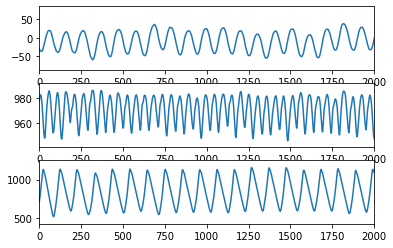

In [65]:
npz_dir = '/content/drive/My Drive/Inseung_LearningAlgos/npz files/'

# from npz files, open the file and truncate data to sync the data so we can extract 6 min of walking data
# main trial started after the rising edge of the synce force plate
com_vec = []
foot_vec_r = []
foot_vec_l = []

# for file_idx, file_name in enumerate(file_list):
# file_name = file_name.split('c3d')[0]+'npz'
# file_header = header_col_list[file_idx]
file_name = file_list[2].split('c3d')[0]+'npz'
file_header = header_col_list[2]

com, foot_r, foot_l, force_r, force_l = extract_data(npz_dir+file_name, file_header, 12, 45)

# Using the gait event detection funciton, comute right and left leg's mid stance and heel contact
gait_event_idx = compute_gait_event(com, foot_r, foot_l)

# Using the gait event and marker data, compute delta P and Q values for each leg
# delta_P_r, delta_P_l, delta_Q_r, delta_Q_l = compute_pelvis_foot_state(com, foot_r, foot_l, gait_event_idx)

range = [0, 2000]
fig, axs = plt.subplots(3)
axs[0].plot(com[:,0])
axs[0].set_xlim(range)
axs[1].plot(com[:,2])
axs[1].set_xlim(range)
axs[2].plot(foot_r[:,1])
axs[2].set_xlim(range)

# # if "AB1_Session1_Right14_Left14" in file_name:
# com_vec.append(com)
# foot_vec_r.append(foot_r)
# foot_vec_l.append(foot_l)
# # Using the compuate delata values, fit a linear model around it
# linear_model_X = LinearRegression().fit(delta_P_r, delta_Q_r[:,0])
# linear_model_Y = LinearRegression().fit(delta_P_r, delta_Q_r[:,1])

# # linear_model_Y = regression.fit(delta_P_r, delta_Q_r[:,1])
# print(file_name)
# print('R2 Value for X: '+str(linear_model_X.score(delta_P_r, delta_Q_r[:,0])))
# print('R2 Value for Y: '+str(linear_model_Y.score(delta_P_r, delta_Q_r[:,1])))
# print(linear_model_X.coef_)
# print(linear_model_Y.coef_)
# print('')

AB1_Session4_Right10_Left12.npz
R2 Value for X: 0.6296494824810202
R2 Value for Y: 0.16259409723096319
[ 1.21390108 -0.33667463 24.58898182  2.88027952 11.3264835 ]
[ 0.04243537 -2.4477036  20.20917585  6.56449017  2.62000032]



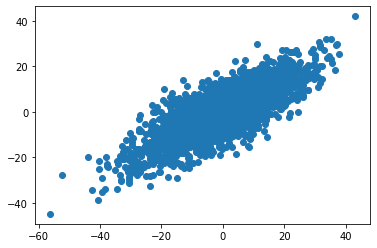

In [139]:
# Obtain state vector for pelvis this is combination of position and velocity which was differentiated
b, a = signal.butter(2, 0.125)

COM_X_r = com[:,0] - foot_r[:,0]
COM_Y_r = com[:,1] - foot_r[:,1]
COM_Z_r = com[:,2] - foot_r[:,2]
COM_X_l = com[:,0] - foot_l[:,0]
COM_Y_l = com[:,1] - foot_l[:,1]
COM_Z_l = com[:,2] - foot_l[:,2]

COM_XX_r = np.append(np.diff(COM_X_r), np.diff(COM_X_r)[-1])
COM_YY_r = np.append(np.diff(COM_Y_r), np.diff(COM_Y_r)[-1])
COM_ZZ_r = np.append(np.diff(COM_Z_r), np.diff(COM_Z_r)[-1])
COM_XX_l = np.append(np.diff(COM_X_l), np.diff(COM_X_l)[-1])
COM_YY_l = np.append(np.diff(COM_Y_l), np.diff(COM_Y_l)[-1])
COM_ZZ_l = np.append(np.diff(COM_Z_l), np.diff(COM_Z_l)[-1])

COM_XX_r = signal.filtfilt(b, a, COM_XX_r)
COM_YY_r = signal.filtfilt(b, a, COM_YY_r)
COM_ZZ_r = signal.filtfilt(b, a, COM_ZZ_r)
COM_XX_l = signal.filtfilt(b, a, COM_XX_l)
COM_YY_l = signal.filtfilt(b, a, COM_YY_l)
COM_ZZ_l = signal.filtfilt(b, a, COM_ZZ_l)

COM_state_r = np.transpose(np.asarray((COM_X_r, COM_Z_r, COM_XX_r, COM_YY_r, COM_ZZ_r)))
COM_state_l = np.transpose(np.asarray((COM_X_l, COM_Z_l, COM_XX_l, COM_YY_l, COM_ZZ_l)))

# Obtain foot placement vector (X, Y). This is only the position vector but we need to subtract the relevant COM position to obtain foot place relative to the COM
footXY_l = np.column_stack((foot_l[:,0] - foot_r[:,0], foot_l[:,1] - foot_r[:,1]))
footXY_r = np.column_stack((foot_r[:,0] - foot_l[:,0], foot_r[:,1] - foot_l[:,1]))

# Obtain COM state and foot placement at mid stance / heel contact for left and right leg using the corresponding gait event index
COM_ms_l = COM_state_l[[int(i) for i in gait_event_idx[:,0].tolist()]]
COM_ms_r = COM_state_r[[int(i) for i in gait_event_idx[:,2].tolist()]]
footXY_hc_l = footXY_l[[int(i) for i in gait_event_idx[:,3].tolist()]]
footXY_hc_r = footXY_r[[int(i) for i in gait_event_idx[:,1].tolist()]]

# compute the nominal P_star and Q_star which is just a mean value during certain part of the gait cycle (mid stance / heel contact)
# delta_P_r = signal.detrend(COM_ms_r, type='linear')
# delta_P_l = signal.detrend(COM_ms_l, type='linear')
# delta_Q_r = signal.detrend(footXY_hc_l, type='linear')
# delta_Q_l = signal.detrend(footXY_hc_r, type='linear')


# Find the nominal trajectory (moving average of the state)
def moving_average(y, N):
  y_final = np.empty(y.shape)
  for idx in np.arange(y.shape[1]):
    y_padded = np.pad(y[:,idx], (N//2, N-1-N//2), mode='edge')
    y_final[:,idx] = np.convolve(y_padded, np.ones((N,))/N, mode='valid')
  return y_final

N =60
COM_ms_norm_l = moving_average(COM_ms_l, N)
COM_ms_norm_r = moving_average(COM_ms_r, N)
footXY_hc_norm_l = moving_average(footXY_hc_l, N)
footXY_hc_norm_r = moving_average(footXY_hc_r, N)


delta_P_r = COM_ms_r - COM_ms_norm_r
delta_P_l = COM_ms_l - COM_ms_norm_l
delta_Q_r = footXY_hc_l - footXY_hc_norm_l
delta_Q_l = footXY_hc_r - footXY_hc_norm_r

# I want to check the running average of different COM values -> to calculate the running Pnorm and Qnorm

# Using the compuate delata values, fit a linear model around it
range = 6000
start = 0
end = start + range

test_start = np.argmin(np.abs(gait_event_idx[:,0] - start))
test_end = np.argmin(np.abs(gait_event_idx[:,0] - end))

linear_model_X = LinearRegression().fit(delta_P_r[start:end,:], delta_Q_r[start:end,0])
linear_model_Y = LinearRegression().fit(delta_P_r[start:end,:], delta_Q_r[start:end,1])

print(file_name)
print('R2 Value for X: '+str(linear_model_X.score(delta_P_r[start:end], delta_Q_r[start:end,0])))
print('R2 Value for Y: '+str(linear_model_Y.score(delta_P_r[start:end], delta_Q_r[start:end,1])))
print(linear_model_X.coef_)
print(linear_model_Y.coef_)
print('')

pred = linear_model_X.predict(delta_P_r[start:end])
plt.plot(delta_Q_r[start:end,0],pred,'o')
plt.show()

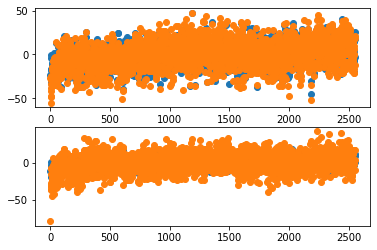

In [67]:
#PLOT the data
pred_X = linear_model_X.predict(delta_P_r)
pred_Y = linear_model_Y.predict(delta_P_r)

fig, axs = plt.subplots(2,1)

axs[0].plot(pred_X,'o')
axs[0].plot(delta_Q_r[:,0],'o')

axs[1].plot(pred_Y,'o')
axs[1].plot(delta_Q_r[:,1],'o')
plt.show()

In [10]:
b, a = signal.butter(2, 0.125)

idx = 4

com = com_vec[idx]
foot_r = foot_vec_r[idx]
foot_l = foot_vec_l[idx]

gait_event_idx = compute_gait_event(com, foot_r, foot_l)

# com_1 = signal.filtfilt(b, a, com)
# foot_r = signal.filtfilt(b, a, foot_r, padlen=len(foot_r)-1)
# foot_l = signal.filtfilt(b, a, foot_l, padlen=len(foot_l)-1)

ms_l = gait_event_idx[:,0].astype(int).tolist()
hc_r = gait_event_idx[:,1].astype(int).tolist()
ms_r = gait_event_idx[:,2].astype(int).tolist()
hc_l = gait_event_idx[:,3].astype(int).tolist()

fig, axs = plt.subplots(2)

axs[0].plot(gait_event_idx - gait_event_idx[:,0].reshape(-1,1))
# plt.show()
# print(gait_event_idx[100:120,:]- gait_event_idx[100:120,0].reshape(-1,1))

axs[1].plot(com[:,1]-foot_r[:,1],'red')
axs[1].plot(com[:,1]-foot_l[:,1],'blue')
axs[1].plot(ms_r, com[ms_r,1]-foot_r[ms_r,1], 'o')
axs[1].plot(hc_l, com[hc_l,1]-foot_l[hc_l,1], 'x')
axs[1].plot(ms_l, com[ms_l,1]-foot_l[ms_l,1], '*')
axs[1].plot(hc_r, com[hc_r,1]-foot_r[hc_r,1], '+')
# plt.xlim(4500, 4750)
plt.show()

IndexError: ignored

NameError: ignored

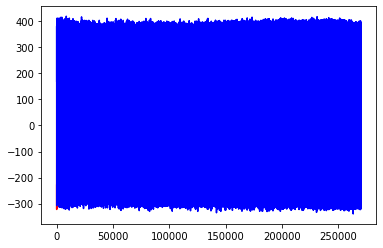

In [11]:
plt.plot(com[:,1]-foot_r[:,1],'red')
plt.plot(com[:,1]-foot_l[:,1],'blue')
plt.plot(ms_r, com[ms_r,1]-foot_r[ms_r,1], 'o')
plt.plot(hc_l, com[hc_l,1]-foot_l[hc_l,1], 'x')
plt.plot(ms_l, com[ms_l,1]-foot_l[ms_l,1], '*')
plt.plot(hc_r, com[hc_r,1]-foot_r[hc_r,1], '+')
plt.xlim(4000, 5000)
plt.show()

NameError: ignored

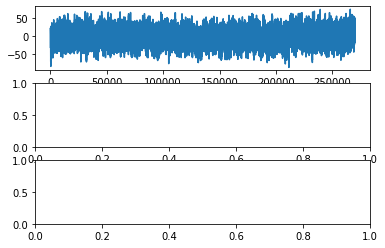

In [12]:
fig, axs = plt.subplots(3)
range = [4000, 5000]
COM_X = com[:,0]
COM_Y = com[:,2]
FOOT_X = foot_l[:,2]

axs[0].plot(COM_X)
axs[0].plot(ms_r, COM_X[ms_r], 'o')

axs[1].plot(COM_Y)
axs[1].plot(ms_r, COM_Y[ms_r], 'o')
axs[1].plot(hc_l, COM_Y[hc_l], 'x')

axs[2].plot(FOOT_X)
axs[2].plot(hc_l, FOOT_X[hc_l],'o')
# axs[2].plot(foot_l[:,0]-foot_r[:,0])
# axs[2].plot(foot_r[:,0]-foot_l[:,0])

axs[0].set_xlim(range)
axs[1].set_xlim(range)
axs[2].set_xlim(range)
plt.show()

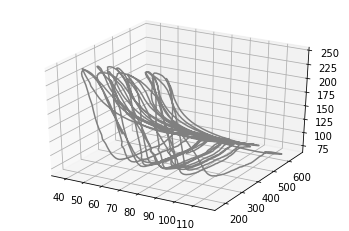

In [ ]:
ax = plt.axes(projection='3d')
ax.plot3D(foot_r[1000:3000,0], foot_r[1000:3000,1], foot_r[1000:3000,2], 'gray')

# plt.plot(foot_r[1000:3000,0])
# plt.show()

# plt.plot(com[:,0])
# plt.plot(foot_r[:,0])
# plt.plot(foot_l[:,0])
# plt.xlim(range)
# plt.show()

In [ ]:
import pandas as pd

mat_dir = '/content/drive/My Drive/Inseung_LearningAlgos/mat files/'
filename = 'testdata.xlsx'
df = pd.read_excel(mat_dir+filename).to_numpy()

In [ ]:
com = df[:,0:3]
foot_r = df[:,3:6]
foot_l = df[:,6:9]
gait_event_idx = compute_gait_event(com, foot_r, foot_l)
delta_P_r, delta_P_l, delta_Q_r, delta_Q_l = compute_pelvis_foot_state(com, foot_r, foot_l, gait_event_idx)

regression = LinearRegression(fit_intercept = False)
linear_model = regression.fit(delta_P_r, delta_Q_r)
pred = linear_model.predict(delta_P_r)
print('R2 Value: '+str(linear_model.score(delta_P_r, delta_Q_r)))




R2 Value: 0.10215784148985868


In [ ]:
# footXY_hc_r_1 = footXY_hc_r

# plt.plot(footXY_hc_r_0[:,0],footXY_hc_r_0[:,1],'o')
# plt.plot(footXY_hc_r_1[:,0],footXY_hc_r_1[:,1],'o')
plt.plot(footXY_hc_r[10:,0],footXY_hc_r[10:,1],'o')
plt.plot(footXY_hc_l[10:,0],footXY_hc_l[10:,1],'x')

# plt.xlim(-200, 400)
plt.ylim(0, 800)
plt.show()

NameError: ignored

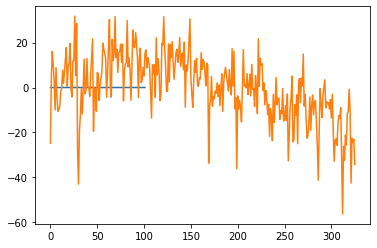

In [ ]:
plt.plot(pred[:,0])
plt.plot(delta_Q_r[:,0])
plt.show()

In [ ]:
plt.plot(delta_Q_r[:,0],pred[:,0], 'o')
# plt.xlim(-20, 20)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

NameError: ignored